<a href="https://colab.research.google.com/github/pluieciel/applied-ml-uni-lu/blob/master/mars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!apt install swig cmake

In [ ]:
%%capture
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit1/requirements-unit1.txt

In [ ]:
xysky = ((0,3000),(0,450),(300,750),(1000,450),(1500,650),(1800,850),(2000,1950),(2200,1850),(2400,2000),(3100,1800),(3150,1550),(2500,1600),(2200,1550),(2100,750),(2200,150),(3200,150),(3500,450),(4000,950),(4500,1450),(5000,1550),(5500,1500),(6000,950),(6999,1750),(7000,3000))

In [ ]:
xyground = ((0,0),(0,450),(300,750),(1000,450),(1500,650),(1800,850),(2000,1950),(2200,1850),(2400,2000),(3100,1800),(3150,1550),(2500,1600),(2200,1550),(2100,750),(2200,150),(3200,150),(3500,450),(4000,950),(4500,1450),(5000,1550),(5500,1500),(6000,950),(6999,1750),(7000,0))

In [ ]:
__credits__ = ["Andrea PIERRÉ"]

import math
import warnings
from typing import TYPE_CHECKING, Optional

import numpy as np

import gymnasium as gym
from gymnasium import error, spaces
from gymnasium.error import DependencyNotInstalled
from gymnasium.utils import EzPickle, colorize
from gymnasium.utils.step_api_compatibility import step_api_compatibility


try:
    import Box2D
    from Box2D.b2 import (
        circleShape,
        contactListener,
        edgeShape,
        fixtureDef,
        polygonShape,
        revoluteJointDef,
    )

except ImportError as e:
    raise DependencyNotInstalled(
        "Box2D is not installed, run `pip install gymnasium[box2d]`"
    ) from e


if TYPE_CHECKING:
    import pygame


FPS = 100
SCALE = 1.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

unitsquare = [(-0.5,-0.5), (0.5,-0.5), (0.5,0.5), (-0.5,0.5)]
LANDER_POLY = [(-140, +170), (-170, 0), (-170, -100), (+170, -100), (+170, 0), (+140, +170)]
FIRE1 = [(0, 0), (-40, -100), (40, -100)]
FIRE2 = [(0, 0), (-20, -80), (20, -80)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14
SIDE_ENGINE_AWAY = 12
MAIN_ENGINE_Y_LOCATION = (
    4  # The Y location of the main engine on the body of the Lander.
)

VIEWPORT_W = 7000
VIEWPORT_H = 3000


class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env

    def BeginContact(self, contact):
        if (
            self.env.lander == contact.fixtureA.body
            or self.env.lander == contact.fixtureB.body
        ):
            self.env.game_over = True


    def EndContact(self, contact):
        pass


class MarsLander(gym.Env, EzPickle):

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": FPS,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        continuous: bool = False,
        gravity: float = -3.711,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    ):
        EzPickle.__init__(
            self,
            render_mode,
            continuous,
            gravity,
            enable_wind,
            wind_power,
            turbulence_power,
        )

        assert (
            -12.0 < gravity and gravity <= 0.0
        ), f"gravity (current value: {gravity}) must be between -12 and 0"
        self.gravity = gravity

        if 0.0 > wind_power or wind_power > 20.0:
            warnings.warn(
                colorize(
                    f"WARN: wind_power value is recommended to be between 0.0 and 20.0, (current value: {wind_power})",
                    "yellow",
                ),
            )
        self.wind_power = wind_power

        if 0.0 > turbulence_power or turbulence_power > 2.0:
            warnings.warn(
                colorize(
                    f"WARN: turbulence_power value is recommended to be between 0.0 and 2.0, (current value: {turbulence_power})",
                    "yellow",
                ),
            )
        self.turbulence_power = turbulence_power

        self.enable_wind = enable_wind
        self.wind_idx = np.random.randint(-9999, 9999)
        self.torque_idx = np.random.randint(-9999, 9999)

        self.screen: pygame.Surface = None
        self.clock = None
        self.isopen = True
        self.world = Box2D.b2World(gravity=(0, gravity))
        self.moon = None
        self.lander: Optional[Box2D.b2Body] = None
        self.particles = []

        self.prev_reward = None

        self.continuous = continuous

        low = np.array(
            [
                # x y vx vy angle power
                0,
                0,
                # velocity bounds is 5x rated speed
                -10000.0,
                -10000.0,
                -math.pi,
                0
            ]
        ).astype(np.float32)
        high = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                7000,
                3000,
                # velocity bounds is 5x rated speed
                10000.0,
                10000.0,
                math.pi,
                4
            ]
        ).astype(np.float32)

        # useful range is -1 .. +1, but spikes can be higher
        self.observation_space = spaces.Box(low, high)

        self.action_space = spaces.Discrete(6) # angle: -15 0 +15  ;  power: -1 +1

        self.render_mode = render_mode

    def _destroy(self):
        if not self.moon:
            return
        self.world.contactListener = None
        self.world.DestroyBody(self.moon)
        self.moon = None
        self.world.DestroyBody(self.lander)
        self.lander = None

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # Create Terrain

        self.moon = self.world.CreateStaticBody(
            shapes=edgeShape(vertices=[(0, 0), (W, 0)])
        )

        for i in range(len(xysky) - 1):
            p1 = xysky[i]
            p2 = xysky[i+1]
            self.moon.CreateEdgeFixture(vertices=[p1, p2], density=0, friction=0.1)
        self.moon.CreateEdgeFixture(vertices=[(0,3000), (7000,3000)], density=0, friction=0.1)

        self.moon.color1 = (0.0, 100, 0.0)
        self.moon.color2 = (0.0, 0.0, 100)

        # Create Lander body
        initial_y = 2600
        initial_x = 6500

        self.lander: Box2D.b2Body = self.world.CreateDynamicBody(
            position=(initial_x, initial_y),
            angle=45/360*2*math.pi,
            fixtures=fixtureDef(
                shape=polygonShape(
                    vertices=unitsquare
                ),
                density=1.0,
                friction=0.1,
                #categoryBits=0x0010,
                #maskBits=0x001,  # collide only with ground
                restitution=0.0,
            ),  # 0.99 bouncy
        )
        self.lander.linearVelocity.x = -20.0

        self.lander.color1 = (0, 0, 255)
        self.lander.color2 = (77, 77, 128)

        self.lander.power = 0


        if self.render_mode == "human":
            self.render()
        return np.array([self.lander.position.x,
                         self.lander.position.y,
                         self.lander.linearVelocity.x,
                         self.lander.linearVelocity.y,
                         self.lander.angle,
                         self.lander.power], dtype=np.float32), {}

    def step(self, action):

        action = divmod(action, 3) # Discrete 6 into MultiDiscrete [2,3]

        cur_angle = self.lander.angle
        new_angle = cur_angle + ((action[1]-1)*15)/360*2*math.pi
        new_angle = np.clip(new_angle, -0.5*math.pi, 0.5*math.pi)
        self.lander.angle = new_angle

        cur_power = self.lander.power
        new_power = cur_power + (action[0]*2-1)
        new_power = np.clip(new_power, 0, 4)
        self.lander.power = new_power

        if not self.game_over:
            for i in range(100):

                self.lander.ApplyForceToCenter((-math.sin(new_angle)*new_power, math.cos(new_angle)*new_power),True,)
                self.world.Step(1.0 / FPS, 200, 200)

        pos = self.lander.position
        vel = self.lander.linearVelocity

        state = [
            (pos.x),
            (pos.y),
            vel.x,
            vel.y,
            new_angle,
            new_power
        ]
        assert len(state) == 6

        reward = 0
        shaping = (
            - 10000 * np.sqrt(((pos.x-2700)/7000)**2+((pos.y-150)/3000)**2) #relative to (2200,150),(3200,150)
            - 10000 * (pos.y-150)/3000
            # - 10 * ((abs(vel.x)+2*abs(vel.y)+abs(new_angle/math.pi*180)) * max(0, (-np.log(5*np.sqrt(((pos.x-2700)/7000)**2+((pos.y-150)/3000)**2)))))
            - 800 * (abs(vel.y) - 40)
            - 100 * (abs(vel.x) - 20)
            - 2 * abs(new_angle/math.pi*180)
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= (
            new_power * 0.3

        )  # less fuel spent is better, about -30 for heuristic landing


        terminated = False

        if 2200<pos.x<3200 and pos.y<155 and abs(vel.x)<=20 and abs(vel.y)<=40 and new_angle==0:
            terminated = True
            reward = +5000
        if self.game_over:
            terminated = True
            reward = -10 * abs(vel.x)+2*abs(vel.y)


        if self.render_mode == "human":
            self.render()
        return np.array(state, dtype=np.float32), reward, terminated, False, {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError as e:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gymnasium[box2d]`"
            ) from e

        if self.screen is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((VIEWPORT_W/10, VIEWPORT_H/10))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface((VIEWPORT_W/10, VIEWPORT_H/10))

        pygame.init()
        pygame.transform.scale(self.surf, (300, 700))
        pygame.draw.rect(self.surf, (255, 255, 255), self.surf.get_rect())
        scaled_xyground = []
        for coord in xyground:
            scaled_xyground.append((coord[0] /10, coord[1] /10))
        pygame.gfxdraw.aapolygon(self.surf, scaled_xyground, (255, 0, 0))
        pygame.draw.polygon(self.surf, (100, 100, 100), scaled_xyground)

        trans = self.lander.fixtures[0].body.transform
        path = [trans * v/10 for v in LANDER_POLY]
        #pygame.draw.polygon(self.surf, color=(0,0,0), points=path)
        pygame.gfxdraw.aapolygon(self.surf, path, (0,0,0))

        f1 = [tuple([int(i*self.lander.power) for i in j]) for j in FIRE1]
        f2 = [tuple([int(i*self.lander.power) for i in j]) for j in FIRE2]
        fire1 = [trans * v/10 for v in f1]
        fire2 = [trans * v/10 for v in f2]
        pygame.draw.polygon(self.surf, color=(230,100,0), points=fire1)
        pygame.draw.polygon(self.surf, color=(200,200,0), points=fire2)

        font = pygame.font.SysFont(None, 30)
        text = font.render(str(int(self.lander.position.x))
                           +"|"+str(int(self.lander.position.y))
                           +"|"+str(int(self.lander.linearVelocity.x))
                           +"|"+str(int(self.lander.linearVelocity.y))
                           +"|"+str(int(self.lander.angle/math.pi*180))
                           +"|"+str(self.lander.power), True, (0, 0, 0))
        text = pygame.transform.flip(text, False, True)
        textRect = text.get_rect()
        textRect.center = (350, 260)
        self.surf.blit(text, textRect)

        self.surf = pygame.transform.flip(self.surf, False, True)
        if self.render_mode == "human":
            assert self.screen is not None
            self.screen.blit(self.surf, (0, 0))
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()
        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.surf)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False



In [ ]:
from gymnasium.envs.registration import (
    load_plugin_envs,
    make,
    pprint_registry,
    register,
    registry,
    spec,
)

In [ ]:
register(
    id='mars',
    entry_point='__main__:MarsLander',
    max_episode_steps=1000,
    reward_threshold=200,
)

In [ ]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import gymnasium as gym

In [ ]:
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env

In [ ]:
env = make_vec_env('mars', n_envs=16)

In [ ]:
model = DQN(
    policy = "MlpPolicy",
    env = env,
    learning_rate=0.0001,
    buffer_size=1000000,
    learning_starts=50000,
    batch_size=64,
    tau=0.8,
    gamma=0.99,
    train_freq=4,
    gradient_steps=1,
    exploration_fraction=0.1, exploration_initial_eps=1.0, exploration_final_eps=0.05,
    stats_window_size=100,
    verbose=1)

Using cuda device


In [ ]:
#del model

In [ ]:
#model = PPO.load('./drive/MyDrive/colab/mars-PPO-4')

In [ ]:
model.env = env

In [ ]:
model = PPO(
    policy = 'MlpPolicy',
    env = env,
    n_steps = 1024,
    batch_size = 64,
    n_epochs = 4,
    gamma = 0.999,
    gae_lambda = 0.98,
    ent_coef = 0.01,
    normalize_advantage = True,
    use_sde = True,

    verbose=1)

Using cuda device


In [ ]:
model.learn(total_timesteps=1000000)

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 64.4      |
|    ep_rew_mean     | -2.73e+04 |
| time/              |           |
|    fps             | 1091      |
|    iterations      | 1         |
|    time_elapsed    | 15        |
|    total_timesteps | 16384     |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 67.5          |
|    ep_rew_mean          | -2.5e+04      |
| time/                   |               |
|    fps                  | 939           |
|    iterations           | 2             |
|    time_elapsed         | 34            |
|    total_timesteps      | 32768         |
| train/                  |               |
|    approx_kl            | 4.3924956e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.415        |
|    explained_variance   | 0.102 

KeyboardInterrupt: ignored

mar5: forget abs(vel), 90degree to left

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [ ]:
model_name = "./drive/MyDrive/colab/mars-PPO-11"
model.save(model_name)

In [ ]:
eval_env = gym.make("mars")
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward=-12927.75 +/- 0.0


-14553.638566079682

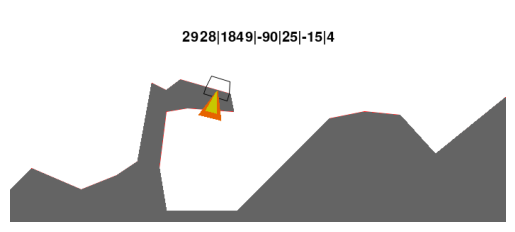

In [ ]:
env = gym.make("mars", render_mode="rgb_array")
#model = PPO.load("ll2")

state, _ = env.reset()
prev_screen = env.render()
plt.imshow(prev_screen)
terminated = False
score = 0
while not terminated:
    action, _ = model.predict(observation=state)
    observation, reward, terminated, truncated, info = env.step(action=action)
    score += reward
    screen = env.render()
    plt.imshow(screen)
    plt.axis('off')
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)
env.close()
score

In [ ]:
# save GIF image
import imageio
import numpy as np

terminated = False
images = []
env = gym.make("mars", render_mode="rgb_array")
state, _ = env.reset()
img = env.render()
while not terminated:
    images.append(img)
    action, _ = model.predict(observation=state)
    observation, reward, terminated, truncated, info = env.step(action=action)
    img = env.render()
env.close()

imageio.mimsave("mars1.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)


In [ ]:
images

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[100, 100, 100],
         [100, 100, 100],
         [100, 100, 100],
         ...,
         [100, 100, 100],
         [100, 100, 100],
         [100, 100, 100]],
 
        [[100, 100, 100],
         [100, 100, 100],
         [100, 100, 100],
         ...,
         [100, 100, 100],
         [100, 100, 100],
         [100, 100, 100]],
 
        [[100, 100, 100],
         [100, 100, 100],
         [100, 100, 100],
         ...,
         [100, 100, 100],
  

other tests

In [ ]:
import imageio
import numpy as np

images = []
obs = model.env.reset()
img = model.env.render(mode="rgb_array")
for i in range(350):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ , _ = model.env.step(action)
    img = model.env.render(mode="rgb_array")

imageio.mimsave("mars1.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)


In [ ]:
%%capture
!sudo apt-get update
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [ ]:
import gymnasium

from huggingface_sb3 import load_from_hub, package_to_hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [ ]:
import gymnasium as gym

In [ ]:
xy = ((0,450),(300,750),(1000,450),(1500,650),(1800,850),(2000,1950),(2200,1850),(2400,2000),(3100,1800),(3150,1550),(2500,1600),(2200,1550),(2100,750),(2200,150),(3200,150),(3500,450),(4000,950),(4500,1450),(5000,1550),(5500,1500),(6000,950),(6999,1750))

In [ ]:
__credits__ = ["Andrea PIERRÉ"]

import math
import warnings
from typing import TYPE_CHECKING, Optional

import numpy as np

import gymnasium as gym
from gymnasium import error, spaces
from gymnasium.error import DependencyNotInstalled
from gymnasium.utils import EzPickle, colorize
from gymnasium.utils.step_api_compatibility import step_api_compatibility


try:
    import Box2D
    from Box2D.b2 import (
        circleShape,
        contactListener,
        edgeShape,
        fixtureDef,
        polygonShape,
        revoluteJointDef,
    )
except ImportError as e:
    raise DependencyNotInstalled(
        "Box2D is not installed, run `pip install gymnasium[box2d]`"
    ) from e


if TYPE_CHECKING:
    import pygame


FPS = 1
SCALE = 30.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14
SIDE_ENGINE_AWAY = 12
MAIN_ENGINE_Y_LOCATION = (
    4  # The Y location of the main engine on the body of the Lander.
)

VIEWPORT_W = 600
VIEWPORT_H = 400


class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env

    def BeginContact(self, contact):
        if (
            self.env.lander == contact.fixtureA.body
            or self.env.lander == contact.fixtureB.body
        ):
            self.env.game_over = True
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = True

    def EndContact(self, contact):
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = False


class LunarLander0(gym.Env, EzPickle):
    """
    ## Description
    This environment is a classic rocket trajectory optimization problem.
    According to Pontryagin's maximum principle, it is optimal to fire the
    engine at full throttle or turn it off. This is the reason why this
    environment has discrete actions: engine on or off.

    There are two environment versions: discrete or continuous.
    The landing pad is always at coordinates (0,0). The coordinates are the
    first two numbers in the state vector.
    Landing outside of the landing pad is possible. Fuel is infinite, so an agent
    can learn to fly and then land on its first attempt.

    To see a heuristic landing, run:
    ```
    python gymnasium/envs/box2d/lunar_lander.py
    ```
    <!-- To play yourself, run: -->
    <!-- python examples/agents/keyboard_agent.py LunarLander-v2 -->

    ## Action Space
    There are four discrete actions available:
    - 0: do nothing
    - 1: fire left orientation engine
    - 2: fire main engine
    - 3: fire right orientation engine

    ## Observation Space
    The state is an 8-dimensional vector: the coordinates of the lander in `x` & `y`, its linear
    velocities in `x` & `y`, its angle, its angular velocity, and two booleans
    that represent whether each leg is in contact with the ground or not.

    ## Rewards
    After every step a reward is granted. The total reward of an episode is the
    sum of the rewards for all the steps within that episode.

    For each step, the reward:
    - is increased/decreased the closer/further the lander is to the landing pad.
    - is increased/decreased the slower/faster the lander is moving.
    - is decreased the more the lander is tilted (angle not horizontal).
    - is increased by 10 points for each leg that is in contact with the ground.
    - is decreased by 0.03 points each frame a side engine is firing.
    - is decreased by 0.3 points each frame the main engine is firing.

    The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

    An episode is considered a solution if it scores at least 200 points.

    ## Starting State
    The lander starts at the top center of the viewport with a random initial
    force applied to its center of mass.

    ## Episode Termination
    The episode finishes if:
    1) the lander crashes (the lander body gets in contact with the moon);
    2) the lander gets outside of the viewport (`x` coordinate is greater than 1);
    3) the lander is not awake. From the [Box2D docs](https://box2d.org/documentation/md__d_1__git_hub_box2d_docs_dynamics.html#autotoc_md61),
        a body which is not awake is a body which doesn't move and doesn't
        collide with any other body:
    > When Box2D determines that a body (or group of bodies) has come to rest,
    > the body enters a sleep state which has very little CPU overhead. If a
    > body is awake and collides with a sleeping body, then the sleeping body
    > wakes up. Bodies will also wake up if a joint or contact attached to
    > them is destroyed.

    ## Arguments
    To use to the _continuous_ environment, you need to specify the
    `continuous=True` argument like below:
    ```python
    import gymnasium as gym
    env = gym.make(
        "LunarLander-v2",
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    )
    ```
    If `continuous=True` is passed, continuous actions (corresponding to the throttle of the engines) will be used and the
    action space will be `Box(-1, +1, (2,), dtype=np.float32)`.
    The first coordinate of an action determines the throttle of the main engine, while the second
    coordinate specifies the throttle of the lateral boosters.
    Given an action `np.array([main, lateral])`, the main engine will be turned off completely if
    `main < 0` and the throttle scales affinely from 50% to 100% for `0 <= main <= 1` (in particular, the
    main engine doesn't work  with less than 50% power).
    Similarly, if `-0.5 < lateral < 0.5`, the lateral boosters will not fire at all. If `lateral < -0.5`, the left
    booster will fire, and if `lateral > 0.5`, the right booster will fire. Again, the throttle scales affinely
    from 50% to 100% between -1 and -0.5 (and 0.5 and 1, respectively).

    `gravity` dictates the gravitational constant, this is bounded to be within 0 and -12.

    If `enable_wind=True` is passed, there will be wind effects applied to the lander.
    The wind is generated using the function `tanh(sin(2 k (t+C)) + sin(pi k (t+C)))`.
    `k` is set to 0.01.
    `C` is sampled randomly between -9999 and 9999.

    `wind_power` dictates the maximum magnitude of linear wind applied to the craft. The recommended value for `wind_power` is between 0.0 and 20.0.
    `turbulence_power` dictates the maximum magnitude of rotational wind applied to the craft. The recommended value for `turbulence_power` is between 0.0 and 2.0.

    ## Version History
    - v2: Count energy spent and in v0.24, added turbulence with wind power and turbulence_power parameters
    - v1: Legs contact with ground added in state vector; contact with ground
        give +10 reward points, and -10 if then lose contact; reward
        renormalized to 200; harder initial random push.
    - v0: Initial version


    ## Notes

    There are several unexpected bugs with the implementation of the environment.

    1. The position of the side thursters on the body of the lander changes, depending on the orientation of the lander.
    This in turn results in an orientation depentant torque being applied to the lander.

    2. The units of the state are not consistent. I.e.
    * The angular velocity is in units of 0.4 radians per second. In order to convert to radians per second, the value needs to be multiplied by a factor of 2.5.

    For the default values of VIEWPORT_W, VIEWPORT_H, SCALE, and FPS, the scale factors equal:
    'x': 10
    'y': 6.666
    'vx': 5
    'vy': 7.5
    'angle': 1
    'angular velocity': 2.5

    After the correction has been made, the units of the state are as follows:
    'x': (units)
    'y': (units)
    'vx': (units/second)
    'vy': (units/second)
    'angle': (radians)
    'angular velocity': (radians/second)


    <!-- ## References -->

    ## Credits
    Created by Oleg Klimov
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": FPS,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        continuous: bool = False,
        gravity: float = 0.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    ):
        EzPickle.__init__(
            self,
            render_mode,
            continuous,
            gravity,
            enable_wind,
            wind_power,
            turbulence_power,
        )

        assert (
            -12.0 < gravity and gravity <= 0.0
        ), f"gravity (current value: {gravity}) must be between -12 and 0"
        self.gravity = gravity

        if 0.0 > wind_power or wind_power > 20.0:
            warnings.warn(
                colorize(
                    f"WARN: wind_power value is recommended to be between 0.0 and 20.0, (current value: {wind_power})",
                    "yellow",
                ),
            )
        self.wind_power = wind_power

        if 0.0 > turbulence_power or turbulence_power > 2.0:
            warnings.warn(
                colorize(
                    f"WARN: turbulence_power value is recommended to be between 0.0 and 2.0, (current value: {turbulence_power})",
                    "yellow",
                ),
            )
        self.turbulence_power = turbulence_power

        self.enable_wind = enable_wind
        self.wind_idx = np.random.randint(-9999, 9999)
        self.torque_idx = np.random.randint(-9999, 9999)

        self.screen: pygame.Surface = None
        self.clock = None
        self.isopen = True
        self.world = Box2D.b2World(gravity=(0, gravity))
        self.moon = None
        self.lander: Optional[Box2D.b2Body] = None
        self.particles = []

        self.prev_reward = None

        self.continuous = continuous

        low = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                -1.5 * SCALE * 2,
                -1.5 * SCALE * 2,
                # velocity bounds is 5x rated speed
                -5000000.0,
                -5000000.0,
                -math.pi,
                -5.0,
                -0.0,
                -0.0,
            ]
        ).astype(np.float32)
        high = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                1.5 * SCALE * 2,
                1.5 * SCALE * 2,
                # velocity bounds is 5x rated speed
                5000000.0,
                5000000.0,
                math.pi,
                5.0,
                1.0,
                1.0,
            ]
        ).astype(np.float32)

        # useful range is -1 .. +1, but spikes can be higher
        self.observation_space = spaces.Box(low, high)

        if self.continuous:
            # Action is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)
        else:
            # Nop, fire left engine, main engine, right engine
            self.action_space = spaces.Discrete(4)

        self.render_mode = render_mode

    def _destroy(self):
        if not self.moon:
            return
        self.world.contactListener = None
        self._clean_particles(True)
        self.world.DestroyBody(self.moon)
        self.moon = None
        self.world.DestroyBody(self.lander)
        self.lander = None
        self.world.DestroyBody(self.legs[0])
        self.world.DestroyBody(self.legs[1])

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # Create Terrain
        CHUNKS = 11
        height = self.np_random.uniform(0, H / 2, size=(CHUNKS + 1,))
        chunk_x = [W / (CHUNKS - 1) * i for i in range(CHUNKS)]
        self.helipad_x1 = chunk_x[CHUNKS // 2 - 1]
        self.helipad_x2 = chunk_x[CHUNKS // 2 + 1]
        self.helipad_y = H / 4
        height[CHUNKS // 2 - 2] = self.helipad_y
        height[CHUNKS // 2 - 1] = self.helipad_y
        height[CHUNKS // 2 + 0] = self.helipad_y
        height[CHUNKS // 2 + 1] = self.helipad_y
        height[CHUNKS // 2 + 2] = self.helipad_y
        smooth_y = [
            0.33 * (height[i - 1] + height[i + 0] + height[i + 1])
            for i in range(CHUNKS)
        ]

        self.moon = self.world.CreateStaticBody(
            shapes=edgeShape(vertices=[(0, 0), (W, 0)])
        )
        self.sky_polys = []
        for i in range(CHUNKS - 1):
            p1 = (chunk_x[i], smooth_y[i])
            p2 = (chunk_x[i + 1], smooth_y[i + 1])
            self.moon.CreateEdgeFixture(vertices=[p1, p2], density=0, friction=0.1)
            self.sky_polys.append([p1, p2, (p2[0], H), (p1[0], H)])

        self.moon.color1 = (0.0, 0.5, 0.0)
        self.moon.color2 = (0.0, 0.0, 0.5)

        # Create Lander body
        initial_y = VIEWPORT_H / SCALE
        initial_x = VIEWPORT_W / SCALE / 2
        self.lander: Box2D.b2Body = self.world.CreateDynamicBody(
            position=(initial_x, initial_y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=polygonShape(
                    vertices=[(x / SCALE, y / SCALE) for x, y in LANDER_POLY]
                ),
                density=5.0,
                friction=0.1,
                categoryBits=0x0010,
                maskBits=0x001,  # collide only with ground
                restitution=0.0,
            ),  # 0.99 bouncy
        )
        self.lander.color1 = (128, 102, 230)
        self.lander.color2 = (77, 77, 128)

        # Apply the initial random impulse to the lander


        # Create Lander Legs
        self.legs = []
        for i in [-1, +1]:
            leg = self.world.CreateDynamicBody(
                position=(initial_x - i * LEG_AWAY / SCALE, initial_y),
                angle=(i * 0.05),
                fixtures=fixtureDef(
                    shape=polygonShape(box=(LEG_W / SCALE, LEG_H / SCALE)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001,
                ),
            )
            leg.ground_contact = False
            leg.color1 = (128, 102, 230)
            leg.color2 = (77, 77, 128)
            rjd = revoluteJointDef(
                bodyA=self.lander,
                bodyB=leg,
                localAnchorA=(0, 0),
                localAnchorB=(i * LEG_AWAY / SCALE, LEG_DOWN / SCALE),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=LEG_SPRING_TORQUE,
                motorSpeed=+0.3 * i,  # low enough not to jump back into the sky
            )
            if i == -1:
                rjd.lowerAngle = (
                    +0.9 - 0.5
                )  # The most esoteric numbers here, angled legs have freedom to travel within
                rjd.upperAngle = +0.9
            else:
                rjd.lowerAngle = -0.9
                rjd.upperAngle = -0.9 + 0.5
            leg.joint = self.world.CreateJoint(rjd)
            self.legs.append(leg)

        self.drawlist = [self.lander] + self.legs

        if self.render_mode == "human":
            self.render()
        return self.step(np.array([0, 0]) if self.continuous else 0)[0], {}

    def _create_particle(self, mass, x, y, ttl):
        p = self.world.CreateDynamicBody(
            position=(x, y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=circleShape(radius=2 / SCALE, pos=(0, 0)),
                density=mass,
                friction=0.1,
                categoryBits=0x0100,
                maskBits=0x001,  # collide only with ground
                restitution=0.3,
            ),
        )
        p.ttl = ttl
        self.particles.append(p)
        self._clean_particles(False)
        return p

    def _clean_particles(self, all):
        while self.particles and (all or self.particles[0].ttl < 0):
            self.world.DestroyBody(self.particles.pop(0))

    def step(self, action):
        assert self.lander is not None

        # Update wind and apply to the lander
        assert self.lander is not None, "You forgot to call reset()"
        if self.enable_wind and not (
            self.legs[0].ground_contact or self.legs[1].ground_contact
        ):
            # the function used for wind is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            wind_mag = (
                math.tanh(
                    math.sin(0.02 * self.wind_idx)
                    + (math.sin(math.pi * 0.01 * self.wind_idx))
                )
                * self.wind_power
            )
            self.wind_idx += 1


            # the function used for torque is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            torque_mag = math.tanh(
                math.sin(0.02 * self.torque_idx)
                + (math.sin(math.pi * 0.01 * self.torque_idx))
            ) * (self.turbulence_power)
            self.torque_idx += 1
            self.lander.ApplyTorque(
                (torque_mag),
                True,
            )

        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(
                action
            ), f"{action!r} ({type(action)}) invalid "

        # Apply Engine Impulses

        # Tip is a the (X and Y) components of the rotation of the lander.
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))

        # Side is the (-Y and X) components of the rotation of the lander.
        side = (-tip[1], tip[0])

        # Generate two random numbers between -1/SCALE and 1/SCALE.
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        '''
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0

            # 4 is move a bit downwards, +-2 for randomness
            # The components of the impulse to be applied by the main engine.
            ox = (
                tip[0] * (MAIN_ENGINE_Y_LOCATION / SCALE + 2 * dispersion[0])
                + side[0] * dispersion[1]
            )
            oy = (
                -tip[1] * (MAIN_ENGINE_Y_LOCATION / SCALE + 2 * dispersion[0])
                - side[1] * dispersion[1]
            )

            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            if self.render_mode is not None:
                # particles are just a decoration, with no impact on the physics, so don't add them when not rendering
                p = self._create_particle(
                    3.5,  # 3.5 is here to make particle speed adequate
                    impulse_pos[0],
                    impulse_pos[1],
                    m_power,
                )
                p.ApplyLinearImpulse(
                    (
                        ox * MAIN_ENGINE_POWER * m_power,
                        oy * MAIN_ENGINE_POWER * m_power,
                    ),
                    impulse_pos,
                    True,
                )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
        '''
        s_power = 0.0
        '''
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation/Side engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                # action = 1 is left, action = 3 is right
                direction = action - 2
                s_power = 1.0

            # The components of the impulse to be applied by the side engines.
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )

            # The constant 17 is a constant, that is presumably meant to be SIDE_ENGINE_HEIGHT.
            # However, SIDE_ENGINE_HEIGHT is defined as 14
            # This casuses the position of the thurst on the body of the lander to change, depending on the orientation of the lander.
            # This in turn results in an orientation depentant torque being applied to the lander.
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            if self.render_mode is not None:
                # particles are just a decoration, with no impact on the physics, so don't add them when not rendering
                p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
                p.ApplyLinearImpulse(
                    (
                        ox * SIDE_ENGINE_POWER * s_power,
                        oy * SIDE_ENGINE_POWER * s_power,
                    ),
                    impulse_pos,
                    True,
                )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
        '''

        self.lander.ApplyForceToCenter(
            (0.0, -4.0),
            True,
        )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        vel = self.lander.linearVelocity

        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2),
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2),
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
            self.lander.angle,
            20.0 * self.lander.angularVelocity / FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0,
        ]
        assert len(state) == 8

        reward = 0
        shaping = (
            -100 * np.sqrt(state[0] * state[0] + state[1] * state[1])
            - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])
            - 100 * abs(state[4])
            + 10 * state[6]
            + 10 * state[7]
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= (
            m_power * 0.30
        )  # less fuel spent is better, about -30 for heuristic landing
        reward -= s_power * 0.03

        terminated = False
        if self.game_over or abs(state[0]) >= 1.0:
            terminated = True
            reward = -100
        if not self.lander.awake:
            terminated = True
            reward = +100

        if self.render_mode == "human":
            self.render()
        return np.array(state, dtype=np.float32), reward, terminated, False, {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError as e:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gymnasium[box2d]`"
            ) from e

        if self.screen is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((VIEWPORT_W, VIEWPORT_H))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface((VIEWPORT_W, VIEWPORT_H))

        pygame.transform.scale(self.surf, (SCALE, SCALE))
        pygame.draw.rect(self.surf, (255, 255, 255), self.surf.get_rect())

        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )
            obj.color2 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )

        self._clean_particles(False)

        for p in self.sky_polys:
            scaled_poly = []
            for coord in p:
                scaled_poly.append((coord[0] * SCALE, coord[1] * SCALE))
            pygame.draw.polygon(self.surf, (0, 0, 0), scaled_poly)
            gfxdraw.aapolygon(self.surf, scaled_poly, (0, 0, 0))

        for obj in self.particles + self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color1,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color2,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )

                else:
                    path = [trans * v * SCALE for v in f.shape.vertices]
                    pygame.draw.polygon(self.surf, color=obj.color1, points=path)
                    gfxdraw.aapolygon(self.surf, path, obj.color1)
                    pygame.draw.aalines(
                        self.surf, color=obj.color2, points=path, closed=True
                    )

                for x in [self.helipad_x1, self.helipad_x2]:
                    x = x * SCALE
                    flagy1 = self.helipad_y * SCALE
                    flagy2 = flagy1 + 50
                    pygame.draw.line(
                        self.surf,
                        color=(255, 255, 255),
                        start_pos=(x, flagy1),
                        end_pos=(x, flagy2),
                        width=1,
                    )
                    pygame.draw.polygon(
                        self.surf,
                        color=(204, 204, 0),
                        points=[
                            (x, flagy2),
                            (x, flagy2 - 10),
                            (x + 25, flagy2 - 5),
                        ],
                    )
                    gfxdraw.aapolygon(
                        self.surf,
                        [(x, flagy2), (x, flagy2 - 10), (x + 25, flagy2 - 5)],
                        (204, 204, 0),
                    )

        self.surf = pygame.transform.flip(self.surf, False, True)

        if self.render_mode == "human":
            assert self.screen is not None
            self.screen.blit(self.surf, (0, 0))
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()
        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.surf)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


def heuristic(env, s):
    """
    The heuristic for
    1. Testing
    2. Demonstration rollout.

    Args:
        env: The environment
        s (list): The state. Attributes:
            s[0] is the horizontal coordinate
            s[1] is the vertical coordinate
            s[2] is the horizontal speed
            s[3] is the vertical speed
            s[4] is the angle
            s[5] is the angular speed
            s[6] 1 if first leg has contact, else 0
            s[7] 1 if second leg has contact, else 0

    Returns:
         a: The heuristic to be fed into the step function defined above to determine the next step and reward.
    """

    angle_targ = s[0] * 0.5 + s[2] * 1.0  # angle should point towards center
    if angle_targ > 0.4:
        angle_targ = 0.4  # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4:
        angle_targ = -0.4
    hover_targ = 0.55 * np.abs(
        s[0]
    )  # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5]) * 1.0
    hover_todo = (hover_targ - s[1]) * 0.5 - (s[3]) * 0.5

    if s[6] or s[7]:  # legs have contact
        angle_todo = 0
        hover_todo = (
            -(s[3]) * 0.5
        )  # override to reduce fall speed, that's all we need after contact

    if env.continuous:
        a = np.array([hover_todo * 20 - 1, -angle_todo * 20])
        a = np.clip(a, -1, +1)
    else:
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05:
            a = 2
        elif angle_todo < -0.05:
            a = 3
        elif angle_todo > +0.05:
            a = 1
    return a


def demo_heuristic_lander(env, seed=None, render=False):
    total_reward = 0
    steps = 0
    s, info = env.reset(seed=seed)
    while True:
        a = heuristic(env, s)
        s, r, terminated, truncated, info = step_api_compatibility(env.step(a), True)
        total_reward += r

        if render:
            still_open = env.render()
            if still_open is False:
                break

        if steps % 20 == 0 or terminated or truncated:
            print("observations:", " ".join([f"{x:+0.2f}" for x in s]))
            print(f"step {steps} total_reward {total_reward:+0.2f}")
        steps += 1
        if terminated or truncated:
            break
    if render:
        env.close()
    return total_reward


class LunarLanderContinuous:
    def __init__(self):
        raise error.Error(
            "Error initializing LunarLanderContinuous Environment.\n"
            "Currently, we do not support initializing this mode of environment by calling the class directly.\n"
            "To use this environment, instead create it by specifying the continuous keyword in gym.make, i.e.\n"
            'gym.make("LunarLander-v2", continuous=True)'
        )




In [ ]:
register(
    id='myenv-v0',
    entry_point='__main__:LunarLander0',
    max_episode_steps=1000,
    reward_threshold=200,
)

/Users/pluieciel/Downloads/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment myenv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


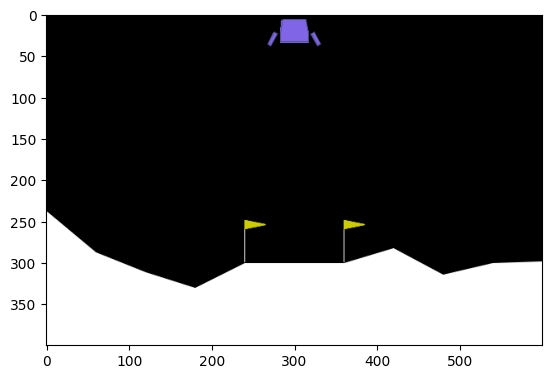

In [ ]:
env = gym.make("myenv-v0", render_mode="rgb_array")
env.reset()
prev_screen = env.render()
plt.imshow(prev_screen)


In [ ]:
action = 0 #env.action_space.sample()
print(0)
observation, reward, terminated, truncated, info = env.step(action)
print(observation, reward, terminated, truncated, info)
screen = env.render()

0
[ 1.4209747e-05 -4.2690709e-02  5.0337596e-09  1.4379490e-09
  1.4029302e-03 -2.2759789e-08  1.0000000e+00  1.0000000e+00] -100 True False {}


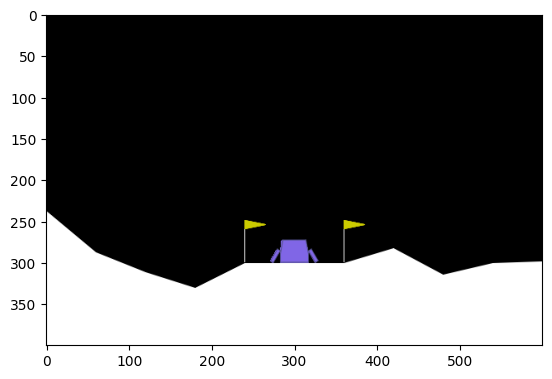

In [ ]:
plt.imshow(screen)
ipythondisplay.clear_output(wait=True)
ipythondisplay.display(plt.gcf())
ipythondisplay.clear_output(wait=True)

(-0.5, 699.5, 299.5, -0.5)

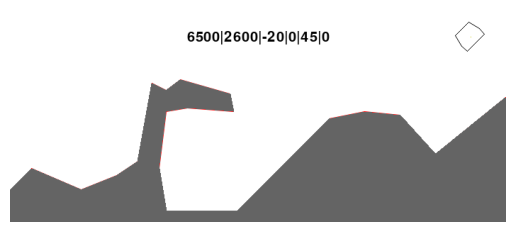

In [ ]:
env = gym.make("mars", render_mode="rgb_array")
env.reset()
prev_screen = env.render()
plt.imshow(prev_screen)
plt.axis('off')

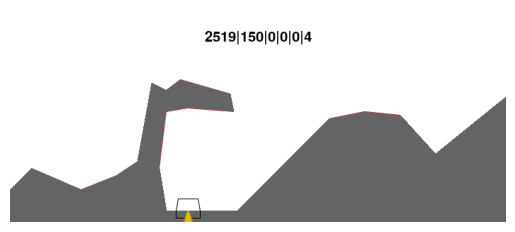

In [ ]:
action = 5 # env.action_space.sample()
print(action)
observation, reward, terminated, truncated, info = env.step(action)
#print(observation, reward, terminated, truncated, info)
screen = env.render()
plt.imshow(screen)
plt.axis('off')
ipythondisplay.clear_output(wait=True)
ipythondisplay.display(plt.gcf())
ipythondisplay.clear_output(wait=True)

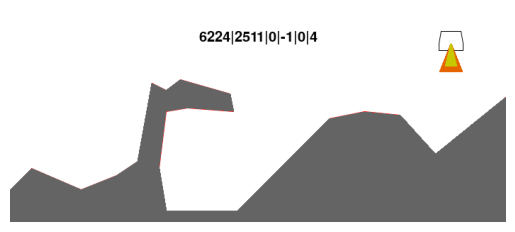

In [ ]:
env.close()

In [ ]:
notebook_login()
!git config --global credential.helper store

In [ ]:
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env

from huggingface_sb3 import package_to_hub

# PLACE the variables you've just defined two cells above
# Define the name of the environment
env_id = "ll"

# TODO: Define the model architecture we used
model_architecture = "PPO"

## Define a repo_id
## repo_id is the id of the model repository from the Hugging Face Hub (repo_id = {organization}/{repo_name} for instance ThomasSimonini/ppo-LunarLander-v2
## CHANGE WITH YOUR REPO ID
repo_id = "pluieciel/lunar" # Change with your repo id, you can't push with mine 😄

## Define the commit message
commit_message = "Upload PPO LunarLander-v2 trained agent"

# Create the evaluation env and set the render_mode="rgb_array"
eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])

# PLACE the package_to_hub function you've just filled here
package_to_hub(model=model, # Our trained model
               model_name=model_name, # The name of our trained model
               model_architecture=model_architecture, # The model architecture we used: in our case PPO
               env_id=env_id, # Name of the environment
               eval_env=eval_env, # Evaluation Environment
               repo_id=repo_id, # id of the model repository from the Hugging Face Hub (repo_id = {organization}/{repo_name} for instance ThomasSimonini/ppo-LunarLander-v2
               commit_message=commit_message)

ℹ This function will save, evaluate, generate a video of your agent,
create a model card and push everything to the hub. It might take up to 1min.
This is a work in progress: if you encounter a bug, please open an issue.


KeyError: ignored

In [ ]:
# action space Discrete 9
__credits__ = ["Andrea PIERRÉ"]

import math
import warnings
from typing import TYPE_CHECKING, Optional

import numpy as np

import gymnasium as gym
from gymnasium import error, spaces
from gymnasium.error import DependencyNotInstalled
from gymnasium.utils import EzPickle, colorize
from gymnasium.utils.step_api_compatibility import step_api_compatibility


try:
    import Box2D
    from Box2D.b2 import (
        circleShape,
        contactListener,
        edgeShape,
        fixtureDef,
        polygonShape,
        revoluteJointDef,
    )

except ImportError as e:
    raise DependencyNotInstalled(
        "Box2D is not installed, run `pip install gymnasium[box2d]`"
    ) from e


if TYPE_CHECKING:
    import pygame


FPS = 100
SCALE = 1.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

unitsquare = [(-0.5,-0.5), (0.5,-0.5), (0.5,0.5), (-0.5,0.5)]
LANDER_POLY = [(-140, +170), (-170, 0), (-170, -100), (+170, -100), (+170, 0), (+140, +170)]
FIRE1 = [(0, 0), (-40, -100), (40, -100)]
FIRE2 = [(0, 0), (-20, -80), (20, -80)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14
SIDE_ENGINE_AWAY = 12
MAIN_ENGINE_Y_LOCATION = (
    4  # The Y location of the main engine on the body of the Lander.
)

VIEWPORT_W = 7000
VIEWPORT_H = 3000


class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env

    def BeginContact(self, contact):
        if (
            self.env.lander == contact.fixtureA.body
            or self.env.lander == contact.fixtureB.body
        ):
            self.env.game_over = True


    def EndContact(self, contact):
        pass


class MarsLander(gym.Env, EzPickle):

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": FPS,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        continuous: bool = False,
        gravity: float = -3.711,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    ):
        EzPickle.__init__(
            self,
            render_mode,
            continuous,
            gravity,
            enable_wind,
            wind_power,
            turbulence_power,
        )

        assert (
            -12.0 < gravity and gravity <= 0.0
        ), f"gravity (current value: {gravity}) must be between -12 and 0"
        self.gravity = gravity

        if 0.0 > wind_power or wind_power > 20.0:
            warnings.warn(
                colorize(
                    f"WARN: wind_power value is recommended to be between 0.0 and 20.0, (current value: {wind_power})",
                    "yellow",
                ),
            )
        self.wind_power = wind_power

        if 0.0 > turbulence_power or turbulence_power > 2.0:
            warnings.warn(
                colorize(
                    f"WARN: turbulence_power value is recommended to be between 0.0 and 2.0, (current value: {turbulence_power})",
                    "yellow",
                ),
            )
        self.turbulence_power = turbulence_power

        self.enable_wind = enable_wind
        self.wind_idx = np.random.randint(-9999, 9999)
        self.torque_idx = np.random.randint(-9999, 9999)

        self.screen: pygame.Surface = None
        self.clock = None
        self.isopen = True
        self.world = Box2D.b2World(gravity=(0, gravity))
        self.moon = None
        self.lander: Optional[Box2D.b2Body] = None
        self.particles = []

        self.prev_reward = None

        self.continuous = continuous

        low = np.array(
            [
                # x y vx vy angle power
                0,
                0,
                # velocity bounds is 5x rated speed
                -10000.0,
                -10000.0,
                -math.pi,
                0
            ]
        ).astype(np.float32)
        high = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                7000,
                3000,
                # velocity bounds is 5x rated speed
                10000.0,
                10000.0,
                math.pi,
                4
            ]
        ).astype(np.float32)

        # useful range is -1 .. +1, but spikes can be higher
        self.observation_space = spaces.Box(low, high)

        self.action_space = spaces.Discrete(9) # angle: -15 0 +15  ;  power: -1 0 +1

        self.render_mode = render_mode

    def _destroy(self):
        if not self.moon:
            return
        self.world.contactListener = None
        self.world.DestroyBody(self.moon)
        self.moon = None
        self.world.DestroyBody(self.lander)
        self.lander = None

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # Create Terrain

        self.moon = self.world.CreateStaticBody(
            shapes=edgeShape(vertices=[(0, 0), (W, 0)])
        )

        for i in range(len(xysky) - 1):
            p1 = xysky[i]
            p2 = xysky[i+1]
            self.moon.CreateEdgeFixture(vertices=[p1, p2], density=0, friction=0.1)
        self.moon.CreateEdgeFixture(vertices=[(0,3000), (7000,3000)], density=0, friction=0.1)

        self.moon.color1 = (0.0, 100, 0.0)
        self.moon.color2 = (0.0, 0.0, 100)

        # Create Lander body
        initial_y = 2600
        initial_x = 6500

        self.lander: Box2D.b2Body = self.world.CreateDynamicBody(
            position=(initial_x, initial_y),
            angle=45/360*2*math.pi,
            fixtures=fixtureDef(
                shape=polygonShape(
                    vertices=unitsquare
                ),
                density=1.0,
                friction=0.1,
                #categoryBits=0x0010,
                #maskBits=0x001,  # collide only with ground
                restitution=0.0,
            ),  # 0.99 bouncy
        )
        self.lander.linearVelocity.x = -20.0

        self.lander.color1 = (0, 0, 255)
        self.lander.color2 = (77, 77, 128)

        self.lander.power = 0


        if self.render_mode == "human":
            self.render()
        return np.array([self.lander.position.x,
                         self.lander.position.y,
                         self.lander.linearVelocity.x,
                         self.lander.linearVelocity.y,
                         self.lander.angle,
                         self.lander.power], dtype=np.float32), {}

    def step(self, action):

        action = divmod(action, 3) # Discrete 9 into MultiDiscrete [3,3]

        cur_angle = self.lander.angle
        new_angle = cur_angle + ((action[0]-1)*15)/360*2*math.pi
        new_angle = np.clip(new_angle, -0.5*math.pi, 0.5*math.pi)
        self.lander.angle = new_angle

        cur_power = self.lander.power
        new_power = cur_power + (action[1]-1)
        new_power = np.clip(new_power, 0, 4)
        self.lander.power = new_power

        if not self.game_over:
            for i in range(100):

                self.lander.ApplyForceToCenter((-math.sin(new_angle)*new_power, math.cos(new_angle)*new_power),True,)
                self.world.Step(1.0 / FPS, 200, 200)

        pos = self.lander.position
        vel = self.lander.linearVelocity

        state = [
            (pos.x),
            (pos.y),
            vel.x,
            vel.y,
            new_angle,
            new_power
        ]
        assert len(state) == 6

        reward = 0
        shaping = (
            - 200 * np.sqrt(((pos.x-2700)/7000)**2+((pos.y-150)/3000)**2) #relative to (2200,150),(3200,150)
            - 10 * ((abs(vel.x)+2*abs(vel.y)+abs(new_angle/math.pi*180)) * max(0, (-np.log(5*np.sqrt(((pos.x-2700)/7000)**2+((pos.y-150)/3000)**2)))))

        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= (
            new_power * 0.3
            + 800 * abs(vel.y)
            + 2 * abs(new_angle/math.pi*180)
        )  # less fuel spent is better, about -30 for heuristic landing


        terminated = False

        if 2200<pos.x<3200 and pos.y<155 and abs(vel.x)<=20 and abs(vel.y)<=40 and new_angle==0:
            terminated = True
            reward = +5000
        if self.game_over:
            terminated = True
            reward = -10 * abs(vel.x)+2*abs(vel.y)


        if self.render_mode == "human":
            self.render()
        return np.array(state, dtype=np.float32), reward, terminated, False, {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError as e:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gymnasium[box2d]`"
            ) from e

        if self.screen is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((VIEWPORT_W/10, VIEWPORT_H/10))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface((VIEWPORT_W/10, VIEWPORT_H/10))

        pygame.init()
        pygame.transform.scale(self.surf, (300, 700))
        pygame.draw.rect(self.surf, (255, 255, 255), self.surf.get_rect())
        scaled_xyground = []
        for coord in xyground:
            scaled_xyground.append((coord[0] /10, coord[1] /10))
        pygame.gfxdraw.aapolygon(self.surf, scaled_xyground, (255, 0, 0))
        pygame.draw.polygon(self.surf, (100, 100, 100), scaled_xyground)

        trans = self.lander.fixtures[0].body.transform
        path = [trans * v/10 for v in LANDER_POLY]
        #pygame.draw.polygon(self.surf, color=(0,0,0), points=path)
        pygame.gfxdraw.aapolygon(self.surf, path, (0,0,0))

        f1 = [tuple([int(i*self.lander.power) for i in j]) for j in FIRE1]
        f2 = [tuple([int(i*self.lander.power) for i in j]) for j in FIRE2]
        fire1 = [trans * v/10 for v in f1]
        fire2 = [trans * v/10 for v in f2]
        pygame.draw.polygon(self.surf, color=(230,100,0), points=fire1)
        pygame.draw.polygon(self.surf, color=(200,200,0), points=fire2)

        font = pygame.font.SysFont(None, 30)
        text = font.render(str(int(self.lander.position.x))
                           +"|"+str(int(self.lander.position.y))
                           +"|"+str(int(self.lander.linearVelocity.x))
                           +"|"+str(int(self.lander.linearVelocity.y))
                           +"|"+str(int(self.lander.angle/math.pi*180))
                           +"|"+str(self.lander.power), True, (0, 0, 0))
        text = pygame.transform.flip(text, False, True)
        textRect = text.get_rect()
        textRect.center = (350, 260)
        self.surf.blit(text, textRect)

        self.surf = pygame.transform.flip(self.surf, False, True)
        if self.render_mode == "human":
            assert self.screen is not None
            self.screen.blit(self.surf, (0, 0))
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()
        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.surf)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

